In [16]:
# import kaggle

In [17]:
# ! kaggle datasets init -p /app/_data/models/complex/hand_complex/

Data package template written to: /app/_data/models/eff4_kf/0865fulltrain/dataset-metadata.json


In [18]:
# ! kaggle datasets create -p /app/_data/models/complex/hand_complex/

Starting upload for file eff4_ns_0865_kf_v2_5.h5
100%|█████████████████████████████████████████| 203M/203M [04:50<00:00, 732kB/s]
Upload successful: eff4_ns_0865_kf_v2_5.h5 (203MB)
Starting upload for file eff4_ns_0865_kf_v2_3.h5
100%|█████████████████████████████████████████| 203M/203M [04:51<00:00, 732kB/s]
Upload successful: eff4_ns_0865_kf_v2_3.h5 (203MB)
Starting upload for file eff4_ns_0865_kf_v2_2.h5
100%|█████████████████████████████████████████| 203M/203M [04:50<00:00, 733kB/s]
Upload successful: eff4_ns_0865_kf_v2_2.h5 (203MB)
Starting upload for file eff4_ns_0865_kf_v2_4.h5
100%|█████████████████████████████████████████| 203M/203M [04:50<00:00, 732kB/s]
Upload successful: eff4_ns_0865_kf_v2_4.h5 (203MB)
Skipping folder: .ipynb_checkpoints; use '--dir-mode' to upload folders
Starting upload for file eff4_ns_0865_kf_v2_1.h5
100%|█████████████████████████████████████████| 203M/203M [04:50<00:00, 732kB/s]
Upload successful: eff4_ns_0865_kf_v2_1.h5 (203MB)
Your private Dataset is

0.891
MODEL_BB_PATH= '../input/model-bb-1/bond_box_999_200.h5'
MODEL_PATH = '../input/0865fulltrain/'
IMAGE_SIZE = (380, 380)
DF_PART = '../input/df-kf-plant/df_kf.csv'
PATH = "/kaggle/input/plant-pathology-2021-fgvc8/"
TRAIN_IMG_PATH = PATH+'train_images/'
TEST_IMG_PATH = PATH+'test_images/'
BATCH_SIZE = 32
NUM_CLASSES=6
SEED = 1488
- replace ''-'scab'
https://www.kaggle.com/nataliayurasova/plant-pathology0891/edit


In [1]:
! pip install albumentations
import albumentations

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import os

import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import tensorflow_addons as tfa
from PIL import Image
from sklearn.model_selection import (
    StratifiedKFold,
    StratifiedShuffleSplit,
    train_test_split,
)
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB4, EfficientNetB7
from tensorflow.keras.layers import (
    AveragePooling2D,
    AvgPool2D,
    Conv2D,
    Dense,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import notebook, tqdm

%matplotlib inline

In [3]:
PATH = "/app/_data/"
BATCH_SIZE = 64
SEED = 42
IMAGE_SIZE = 380
NUM_CLASSES = 6
TRAIN_IMG_PATH = "/app/_data/380_npy/"
TEST_IMG_PATH = "/app/_data/test_images/"
feature_columns = [
    "complex",
    "frog_eye_leaf_spot",
    "healthy",
    "powdery_mildew",
    "rust",
    "scab",
]
wrong = ['ead085dfac287263.jpg', '95276ccd226ad933.jpg',"da8770e819d2696d.jpg", 'cd3a1d64e6806eb5.jpg', 'ccec54723ff91860.jpg']

In [4]:
df_labels = pd.read_csv("../_data/df_csv/labels_21_20.csv", index_col=[0])
df_labels = df_labels.query('image not in @wrong').reset_index(drop=True)

df_labels["image"] = df_labels["image"].str.replace(".jpg", ".npy")

In [5]:
df_labels = df_labels.sample(frac=1, random_state=SEED)

In [6]:
df_labels.shape

(20225, 8)

In [7]:
# df = labels_21_20.copy()
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.07, random_state=SEED)

# for train_index, valid_index in sss.split(df["image"], df["labels"]):
#     train, valid = df.loc[train_index], df.loc[valid_index]

In [8]:
# for 380*380
transform = albumentations.Compose(
    [
        albumentations.CLAHE(p=0.1, clip_limit=(1, 3), tile_grid_size=(8, 8)),
        albumentations.OneOf(
            [
                albumentations.MotionBlur((3, 5)),
                albumentations.MedianBlur(blur_limit=5),
                albumentations.GaussianBlur(blur_limit=(3, 5), sigma_limit=0),
                albumentations.Blur(blur_limit=(3, 5)),
            ],
            p=0.2,
        ),
        albumentations.OneOf(
            [
                albumentations.GaussNoise(var_limit=[10, 70], mean=1),
                albumentations.ISONoise(intensity=(0.1, 1), color_shift=(0.05, 0.25)),
                albumentations.ImageCompression(
                    quality_lower=50, quality_upper=100, compression_type=1
                ),
                albumentations.MultiplicativeNoise(
                    multiplier=(0.9, 1.1), per_channel=True, elementwise=True
                ),
                albumentations.Downscale(
                    scale_min=0.6, scale_max=0.99, interpolation=4
                ),
            ],
            p=0.5,
        ),
        albumentations.OneOf(
            [
                albumentations.HueSaturationValue(
                    hue_shift_limit=(-15, 15),
                    sat_shift_limit=(-20, 20),
                    val_shift_limit=(-20, 20),
                ),
                albumentations.RandomBrightnessContrast(
                    brightness_limit=0.35,
                    contrast_limit=0.35,
                    brightness_by_max=True,
                ),
            ],
            p=0.5,
        ),
        albumentations.OneOf(
            [
                albumentations.OpticalDistortion(
                    distort_limit=0.05,
                    shift_limit=0.05,
                    border_mode=2,
                ),
                albumentations.ElasticTransform(
                    alpha=2.0,
                    sigma=50.0,
                    alpha_affine=10.0,
                    interpolation=0,
                    border_mode=2,
                ),
                albumentations.GridDistortion(
                    num_steps=5, distort_limit=0.3, interpolation=0, border_mode=2
                ),
            ],
            p=0.5,
        ),
        albumentations.OneOf(
            [
                albumentations.HorizontalFlip(),
                albumentations.VerticalFlip(),
            ],
            p=0.5,
        ),
        albumentations.OneOf(
            [
                albumentations.Rotate(
                    limit=(-180, 180), interpolation=0, border_mode=2
                ),
                albumentations.ShiftScaleRotate(
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=360,
                    interpolation=0,
                    border_mode=2,
                ),
            ],
            p=0.5,
        ),
        albumentations.CoarseDropout(p=0.3, max_holes=5, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8),
        albumentations.RandomFog( p=0.5, fog_coef_lower=0.1, fog_coef_upper=0.4, alpha_coef=0.05),


    ]
)

In [9]:
class Generator(keras.utils.Sequence):
    def __init__(
        self,
        df,
        images_src_dir,
        batch_size,
        target_image_size,
        shuffle=False,
        augment=True,
        crop=False,
        resize=False,
        normalize=False,
    ):
        self.shuffle = shuffle
        self.batch_size = BATCH_SIZE
        self.df = df
        self.images_dir = images_src_dir
        self.target_image_size = (IMAGE_SIZE, IMAGE_SIZE)
        self.augment = augment
        self.crop = crop
        self.resize = resize
        self.normalize = normalize
        # create label index map
        self.labels = self._read_labels()
        self.n_samples = self.df.shape[0]
        self.n_batches = self.n_samples // self.batch_size
        # shuffle data, also repeated after each epoch if needed
        if self.shuffle:
            np.random.shuffle(self.labels)

    def _read_labels(self):
        """
        Returns list images mapping to 1-hot label
        """

        # label indexes
        label_ixs = self.df[feature_columns].values
        image_ixs = self.df["image"].values
        labels = []

        for i in range(len(image_ixs)):
            labels.append([image_ixs[i], label_ixs[i]])
        return labels

    def __len__(self):
        """
        Length in batches
        """
        return self.n_batches

    def __getitem__(self, b_ix):
        """
        Produce batch, by batch index
        """

        assert b_ix < self.n_batches

        b_X = np.zeros(
            (self.batch_size, self.target_image_size[0], self.target_image_size[1], 3),
            dtype=np.uint8,
        )

        b_Y = np.zeros(
            (self.batch_size, self.df[feature_columns].shape[1]),
            dtype=np.uint8,
        )

        for i in range(self.batch_size):
            b_X[i], b_Y[i] = self.get_one(
                i + self.batch_size * b_ix,
            )

        return (b_X, b_Y)

    def get_one(self, one_ix):
        """
        Get single item by absolute index
        """
        id = self.labels[one_ix][0]
        src_file = self.images_dir + id

        # read file
        x = np.load(src_file)
        if self.crop:
            coord = self.df[self.df["image"] == id][
                ["x_min", "y_min", "x_max", "y_max"]
            ].values[0]
            orig_hight = x.shape[0]
            orig_width = x.shape[1]
            x_min = coord[0]
            y_min = coord[1]
            x_max = coord[2]
            y_max = coord[3]
            x = x[
                np.int(y_min * orig_hight) : np.int(y_max * orig_hight),
                np.int(x_min * orig_width) : np.int(x_max * orig_width),
            ]

        y = self.labels[one_ix][1]

        # augment
        if self.augment:
            x = self._augment_image(x)

        # normalize (sample-wise)
        if self.normalize:
            x = x.astype(np.float32)
            x = x - np.mean(x, axis=(0, 1))
            x = x / np.std(x, axis=(0, 1))
        return x.astype(np.uint8), y

    def _augment_image(self, x):
        """
        Randomply augment image
        """

        x = transform(image=x)["image"]
        return x

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.labels)

In [10]:
gen_train = Generator(
        df=df_labels.head(100),
        images_src_dir=TRAIN_IMG_PATH,
        target_image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        augment=True,
        crop=False,
        resize=False,
    )

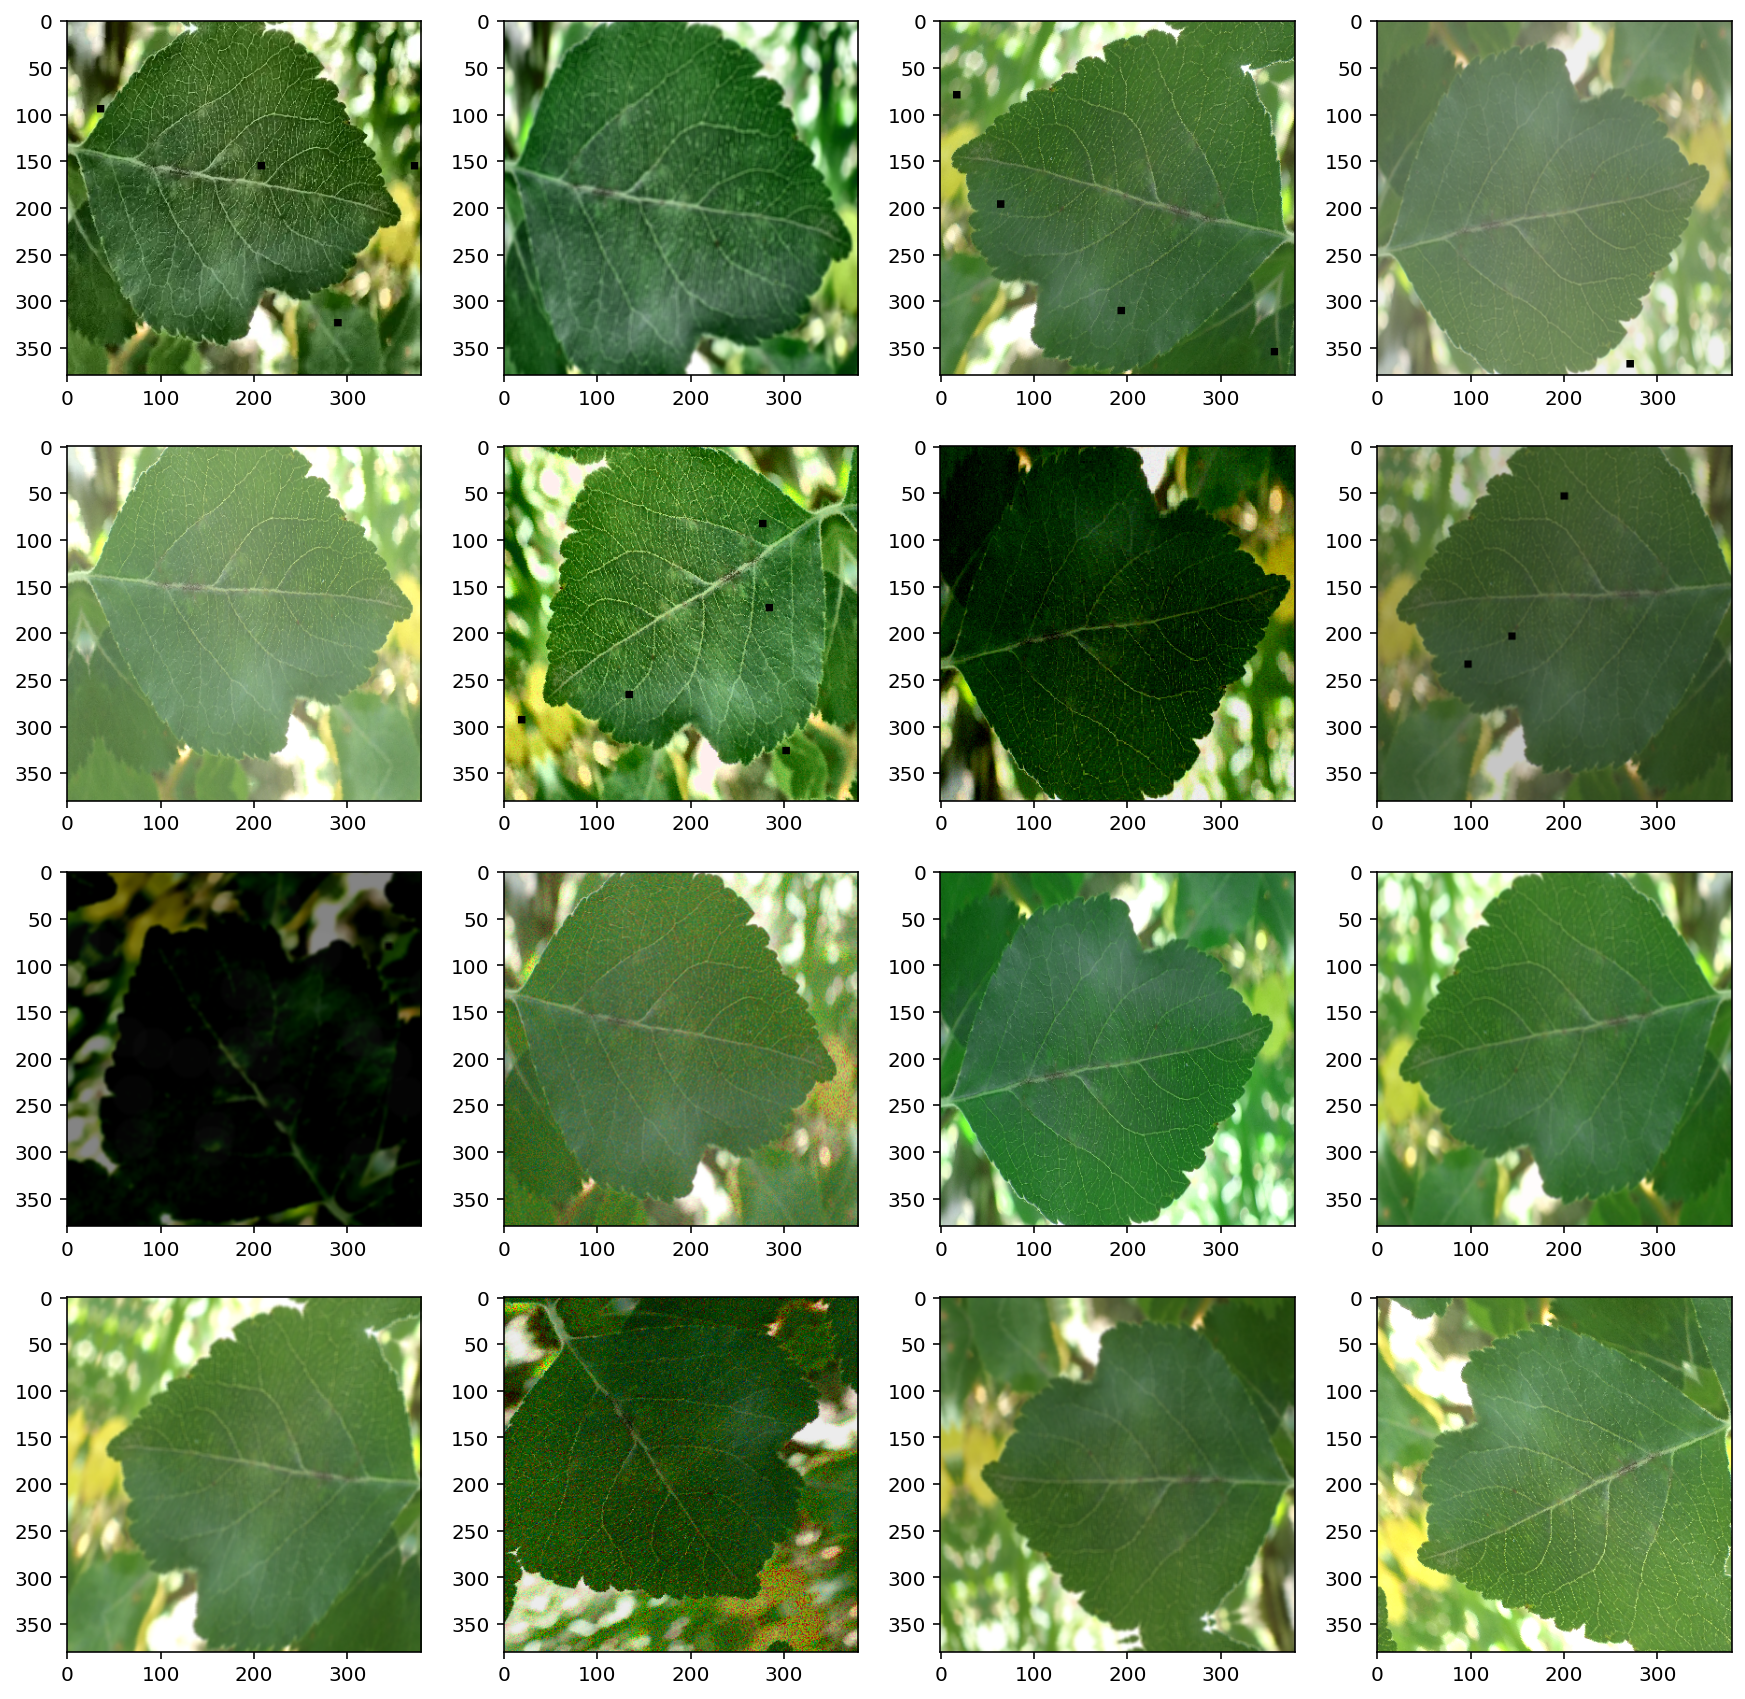

In [11]:
plt.figure(figsize=(15,15))
for i in range(1, 17):
    plt.subplot(4,4,i)
    plt.imshow(gen_train.get_one(11)[0])
plt.show();

In [12]:
policy = keras.mixed_precision.experimental.Policy("mixed_float16")
keras.mixed_precision.experimental.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA Quadro RTX 5000, compute capability 7.5


In [13]:
def get_model():
    inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    base_model = keras.applications.EfficientNetB4(weights=None, include_top=False)
    base_model.load_weights(
        "/app/_data/models/efficientnet-b4_noisy-student_notop.h5",
        by_name=True,
        skip_mismatch=True,
    )
    x = base_model(inputs)
    x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = keras.layers.Flatten(name="flatten")(x)
    outputs = keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(lr=0.0005),
        metrics=[
            "acc",
            keras.metrics.Recall(),
            keras.metrics.Precision(),
            tfa.metrics.F1Score(num_classes=NUM_CLASSES, average="weighted"),
        ],
    )
    return model

In [14]:
BATCH_SIZE = 32

In [ ]:
skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)

for i, (train_index, valid_index) in enumerate(
    skf.split(df_labels["image"], df_labels["labels"])
):
    train, valid = df_labels.loc[train_index], df_labels.loc[valid_index]
    model_name = "eff4_0891_alb" + str(i + 1) + ".h5"
    log_dir = 'logs_0891_alb_'+str(i + 1)+'/'
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_f1_score",
            patience=10,
            restore_best_weights=True,
            verbose=1,
            mode="max",
        ),
        keras.callbacks.ModelCheckpoint(
            "/app/_data/models/final/augm/" + model_name,
            monitor="val_f1_score",
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode="max",
            save_freq="epoch",
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_f1_score",
            factor=0.8,
            patience=4,
            verbose=1,
            mode="max",
            min_delta=1e-4,
            min_lr=0.00000001,
        ),
        keras.callbacks.TensorBoard(
            log_dir="/app/.tensorboard/"+log_dir, histogram_freq=0
        ),
        keras.callbacks.experimental.BackupAndRestore(
    '/app/_data/models/final/augm/backup/'
)
    ]

    gen_train = Generator(
        df=train,
        images_src_dir=TRAIN_IMG_PATH,
        target_image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        augment=True,
        crop=False,
        resize=False,
    )
    gen_valid = Generator(
        df=valid,
        images_src_dir=TRAIN_IMG_PATH,
        target_image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        augment=False,
        crop=False,
        resize=False,
    )
    model = get_model()
    history = model.fit(
        gen_train,
        validation_data=gen_valid,
        epochs=100,
        steps_per_epoch=train.shape[0]//BATCH_SIZE,
        validation_steps=valid.shape[0]//BATCH_SIZE,
        verbose=1,
        workers = 5,
        callbacks=callbacks,
    )
    tf.keras.backend.clear_session()

Epoch 1/100
  1/505 [..............................] - ETA: 0s - loss: 0.7231 - acc: 0.0938 - recall: 0.6970 - precision: 0.2018 - f1_score: 0.0978WARNING:tensorflow:From /usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
505/505 [==============================] - ETA: 0s - loss: 0.1636 - acc: 0.8165 - recall: 0.7740 - precision: 0.8454 - f1_score: 0.8042
Epoch 00001: val_f1_score improved from -inf to 0.84668, saving model to /app/_data/models/final/augm/eff4_0891_alb1.h5
505/505 [==============================] - 361s 715ms/step - loss: 0.1636 - acc: 0.8165 - recall: 0.7740 - precision: 0.8454 - f1_score: 0.8042 - val_loss: 0.1065 - val_acc: 0.8698 - val_recall: 0.8741 - val_precision: 0.8823 - val_f1_score: 0.8467
Epoch 2/100
505/505 [==============================] - ETA: 0s - loss:

In [ ]:
tf.config.list_physical_devices("GPU")

In [30]:
def parse_all(file_path):
    img = tf.io.read_file(TRAIN_IMG_PATH + file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img


def predict_new(path, model):
    img = parse_all(path)
    img = tf.expand_dims(img, axis=0)
    pred = model.predict(img)
    return pred_to_labels(pred[0])

In [31]:
df_sub = pd.DataFrame(columns=["image", "labels"])
for img_name in os.listdir(TRAIN_IMG_PATH):
    pred = predict_new(img_name, model)

    df_sub = df_sub.append({"image": img_name, "labels": pred}, ignore_index=True)

print(df_sub.head())

                  image                   labels
0  bfc6d90f402f4c34.jpg  frog_eye_leaf_spot scab
1  9eb93fe282326266.jpg           powdery_mildew
2  f4cb3a8f41b413e4.jpg       frog_eye_leaf_spot
3  98322eab16bef2c1.jpg                     rust
4  dad5d6250cae80b7.jpg                  complex


In [32]:
df_sub = df_sub.merge(
    labels_21_20[["image", "labels"]],
    on="image",
    how="left",
    suffixes=("_pred", "_true"),
)

In [33]:
df_sub.to_csv("/app/sandbox/wrong_predictions/eff4/eff4_ns_cropped_2.csv")

In [35]:
df_sub[df_sub["labels_pred"] == ""]["labels_true"].value_counts()

complex                    22
scab                       10
rust                        7
frog_eye_leaf_spot          5
scab frog_eye_leaf_spot     1
rust frog_eye_leaf_spot     1
powdery_mildew complex      1
powdery_mildew              1
healthy                     1
Name: labels_true, dtype: int64

In [37]:
df_sub[df_sub["labels_pred"] != df_sub["labels_true"]]["labels_true"].value_counts()

scab frog_eye_leaf_spot            682
complex                            438
scab frog_eye_leaf_spot complex    200
frog_eye_leaf_spot complex         165
scab                               124
rust frog_eye_leaf_spot            118
rust complex                        91
powdery_mildew complex              87
rust                                74
frog_eye_leaf_spot                  71
healthy                             19
powdery_mildew                       7
Name: labels_true, dtype: int64